# Support vector classification

In this notebook we will explore Support Vector Classifier (SVC). Linear binary SVC is very similar to the perceptron and logistic regression in a sense that it finds the optimal hyperplane to separate two classes. These methods, however, have different objectives through which they decide what is the optimal decision boundary.

There are three different SVC classifiers in `sklearn` library:
1. `LinearSVC` implements linear classifier optimised for performance but does not support the kernel trick
2. `SVC` implements SVC with kernel trick. Setting `kernel='linear'` produces the same result as `LinearSVC` but is less efficient in terms of computational time. Setting `kernel='rbf'` produces non-linear classifier with Gaussian kernel.
3. `SGDclassifier` implements various classifiers that are optimised using stochastic gradient descent. Its default setting for loss function is `loss='hinge'` which is another implementation of a linear SVC.

SVC result also depends on hyperparameter `C` which controls the width of the margin and regularises the decision function. Larger `C` means smaller margin, less regularisation, and closer approximation of hard margin objective. Smaller `C` means larger margin, and smoother boundary for non-linear SVC. Note, that `C` has an opposite role to the parameter `alpha` that we used for penalised regression (e.g. `Ridge`). This is because it multiplies the data term rather than the penalty term.

### Libraries 

Run the code below to import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

### Dataset

We will initially consider a  binary dataset with **Healthy** and **Heart Failure** patients, and with features **EF** and **QRS**. The code contains function `PlotData` that is suitable for both 2 and 3 label datasets.

Run the code.

Feature matrix X dimensions:  (120, 2)
Target vector y dimensions:  (120,)
Labels:  [0. 1.]


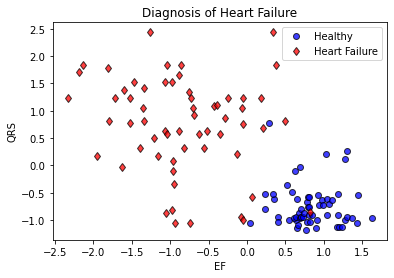

In [2]:
# read fine into a dataframe object
df = pd.read_csv('datasets/heart_failure_data_complete.csv')
# convert dataframe to numpy array
data = df.to_numpy()
# Create feature matrix with EF and QRS
X = data[:,[1,3]]
X = StandardScaler().fit_transform(X)
# Create label vector 
y = data[:,0]
y[y==2]=1
# print properties
print('Feature matrix X dimensions: ', X.shape)
print('Target vector y dimensions: ', y.shape)
print('Labels: ', np.unique(y))

# Generalised for 2 or 3 of classes
def PlotData(X,y):
    # number of labels
    c = (y.max()+1).astype(int)
    # marker styles
    m = ['bo','rd','g^']
    # plot all classes
    for k in range(0,c):
        plt.plot(X[y==k,0],X[y==k,1],m[k],alpha=0.75,markeredgecolor='k')
        
    plt.title('Diagnosis of Heart Failure')
    plt.xlabel('EF')
    plt.ylabel('QRS')
    
    if c == 2:
        plt.legend(['Healthy','Heart Failure'])
    if c == 3:
        plt.legend(['Healthy','Mild HF','Severe HF'])
        
# call the function to plot the dataset
PlotData(X,y)

### Functions

The code below contains functions for plotting the classification results and evaluation of performance. The are:
* `PlotClassification` plots the predicted labels for the feature space
* `PlotDecisionFunction` plots the decision boundary and margins. If `plotSV=True` it also plots the support vectors. If `plotDF=True` it also plots the decision function.
* `EvaluatePerformance` calculates and prints accuracy, class-dependent recalls and class-averaged recalls using cross-validation.

In [3]:
def PlotClassification(model,X,y):

    # Create an 1D array of samples for each feature
    x1 = np.linspace(-2.5, 2, 1000) 
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 

    # Predict labels for the whole feature space    
    y_pred = model.predict(Feature_space)
    # Resahpe to 2D
    y_pred = y_pred.reshape(x1.shape)
    # Plot using contourf
    plt.contourf(x1, x2, y_pred, cmap = 'summer')
    
    # Plot data
    PlotData(X,y)

def PlotDecisionBoundary(model,X,y, plotSV = False, plotDF = False):
        
    # Create an 1D array of samples for each feature
    x1 = np.linspace(-2.5, 2, 1000) 
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 

    # Predict decision function
    df = model.decision_function(Feature_space)
    # Resahpe to 2D
    df = df.reshape(x1.shape)
    # Zero countour is decision boundary, isolines +-1 are the margins
    contour = plt.contour(x1, x2, df,[-1,0,1],colors='k',linestyles=('dashed', 'solid', 'dashed'))
    plt.clabel(contour, inline=1, fontsize=14)
    # Plot decision function
    if plotDF:
        plt.contourf(x1, x2, df, cmap = 'summer')
    
    # plot support vectors
    if plotSV:
        svs = model.support_vectors_
        plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA', label = 'Support vectors',edgecolor='k')
    
    # plot data
    PlotData(X,y)
    
def EvaluatePerformance(model,X,y):
    
    # accuracy
    scores = cross_val_score(model,X,y)
    print('Accuracy: ', round(scores.mean(),2))
    
    # Predict labels using cross-validation
    y_pred = cross_val_predict(model,X,y)

    # calculate recalls for all classes
    recalls = recall_score(y,y_pred,average=None)
    print('Recalls for all classes: ', np.around(recalls,2))
    
    # calculate recall averaged over classes
    mean_recall_macro = recall_score(y,y_pred,average='macro')
    print('Average Recall macro: ', np.around(mean_recall_macro,2))

### Linear SVC

We will first fit linear SVC using `LinearSVC` to our dataset.

**Activity 1:** The code below fits the default linear SVC to the dataset. Perform following
* Plot classification result using `PlotClassification`
* Calculate performance metrics using `EvaluatePerformance`

Accuracy:  0.96
Recalls for all classes:  [0.98 0.93]
Average Recall macro:  0.96


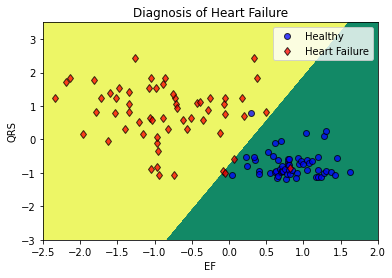

In [4]:
# create the model
model = LinearSVC()
# fit the model
model.fit(X,y)
# Plot classification result
PlotClassification(model,X,y)
# Evaluate performance
EvaluatePerformance(model,X,y)

**Activity 2:** Plot decision boundary and the margins using `PlotDecisionBoundary`

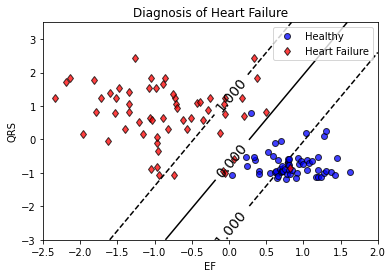

In [5]:
# plot decision boundary and margins
PlotDecisionBoundary(model,X,y)

### Support vectors
LinearSVC does not return the support vectors. We can instead use kernel `SVC` with `kernel='linear'`.

**Activity 3:** Plot the decision boundary and support vectors by calling `PlotDecisionBoundary` with parameter `plotSV=True`.

**Activity 4:** Set the parameter `C` to different values and plot the decision boundary and margin. Observe how margin increases with smaller `C`. You can try values `10`,`1`,`0.1` and `0.01`.

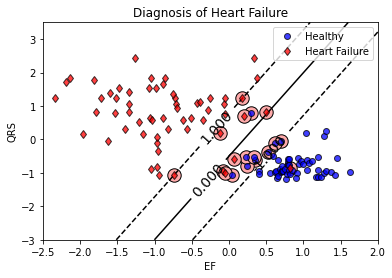

In [6]:
# create model
model = SVC(kernel='linear', C=1)
# fit the model
model.fit(X,y)
# plot decision boundary with support vectors
PlotDecisionBoundary(model,X,y, plotSV=True)

### Kernel SVC

Now we will explore non-linear kernel SVC.

**Activity 5:** Perform following tasks:
* Fit the kernel `SVC` model as in Activity 3, but this time set `kernel='rbf'` which is the Gaussian kernel. 
* Plot the decision boundary and margins.
* Plot also the decision function by setting `plotDF=True`
* The kernel size is controlled by parameter `gamma`. Vary the parameter values to see the effect on a decision boundary. You can try values `10`,`1`,`0.1` and `0.01`.
* Delete the parameter `gamma` to restore it to the default value. Now vary values of parameter `C` to see the effect on the non-linear decision boundary. You can try values `1000`, `10`, `0.1`.

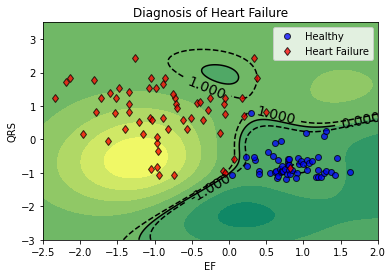

In [7]:
# create model
model = SVC(kernel='rbf',C=1000)
# fit the model
model.fit(X,y)
# plot decision boundary and margins
PlotDecisionBoundary(model,X,y, plotDF=True)

# Exercise 4: Kernel SVC

In this exercise we will tune Kernel SVC to diagnose mild and severe heart failure from **EF** and **QRS**. We will tune and compare `SVC` with linear and Gaussian kernel.

### Task 1: Dataset
First we will update the dataset. The feature matrix is unchanged, but we need to create the label vector `y2` with all three original labels. The updated labels vector is created for you. Plot the dataset.

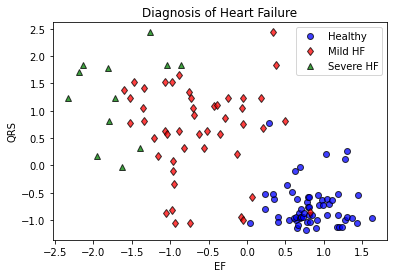

In [8]:
# Create label vector with 3 labels
data2 = df.to_numpy()
y2 = data2[:,0]

# Plot the dataset
PlotData(X,y2)

### Task 2: Tune SVC with Linear Kernel
We will first fit the linear `SVC` with optimal parameter `C` found by grid search. Perform the following:
* Complete the code to tune linear `SVC` model. What is the optimal `C`?
* Evaluate the performance of this model. Does it perform badly for one of the classes?
* Plot classification result using `PlotClassification`

**Answer:** The best `C` is 1. The classifier performs badly for class 2 (Severe HF), detecting only 42% of cases.

In [9]:
# create model
model = SVC(kernel='linear')
# parameter grid
param = {'C':np.logspace(-3,3,13)}
# create grid search
g = GridSearchCV(model,param,cv=5)
# run the grid search
g.fit(X,y2)
# save best model
modelLin = g.best_estimator_
# print best C
print('Best C: ',round(modelLin.C,2))

Best C:  1.0


In [10]:
# Evaluate performance of the fitted model
EvaluatePerformance(modelLin,X,y2)

Accuracy:  0.89
Recalls for all classes:  [0.98 0.9  0.42]
Average Recall macro:  0.77


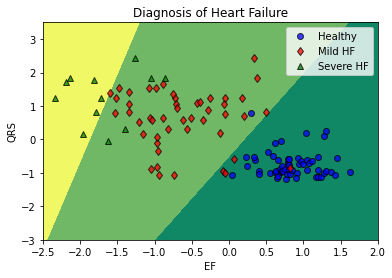

In [11]:
# plot classification result
PlotClassification(modelLin,X,y2)

### Task 3: Tune SVC with Gaussian kernel
Now we will explore whether the non-linear classifier can improve performance. We will set the kernel to `rbf` to produce Gaussian kernel. We need to tune parameters `C` and `gamma` this time. Parameter `gamma` is related to the width of the Gaussian kernel by $\gamma=\frac{1}{2\sigma^2}$.

Perform the following:
* Complete the code to tune Gaussian kernel `SVC`. What is the best `C` and `gamma`?
* Evaluate performance of the tuned non-linear classifier. How does is compare to the linear one in terms of overall performance and for the worst performing class in linear `SVC`?
* Plot the classification result

**Answer:** Best `C` is 3' and best `gamma` is 1. Overall performance measured by accuracy and average recall have both improved. Recall for the worst performing class, severe HF has increased from 0.42 to 0.67

In [12]:
# create model
model = SVC(kernel='rbf')
# parameter grid
param = {'C':np.logspace(-3,3,13),
        'gamma':np.logspace(-3,3,13)}
# create grid search
g = GridSearchCV(model,param,cv=5)
# run the grid search
g.fit(X,y2)
# save best model
modelGauss = g.best_estimator_
# print best C
print('Best C: ',round(modelGauss.C,2))
# print best gamma
print('Best gamma: ',round(modelGauss.gamma,2))

Best C:  31.62
Best gamma:  1.0


In [13]:
# Evaluate performance
EvaluatePerformance(modelGauss,X,y2)

Accuracy:  0.92
Recalls for all classes:  [0.97 0.92 0.67]
Average Recall macro:  0.85


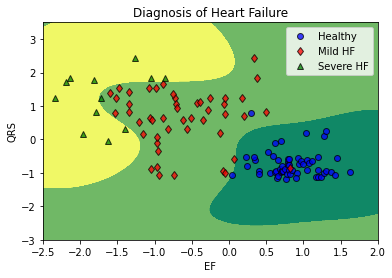

In [14]:
# Plot result
PlotClassification(modelGauss,X,y2)